# What are Most Optimal Skills?

#### Methodology
1. Group skills by median salary and likelihood of appearing in posting
2. Visualize

### Loading and Cleaning

In [218]:
# importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
from adjustText import adjust_text


# loading data set
df = pd.read_csv("C:\\Users\\Dell\\Documents\\VSCODE\\Python\\Data Analysis\\Data\\data_jobs.csv")

# data cleaning
df.job_posted_date = pd.to_datetime(df.job_posted_date)
df['job_skills'] = df['job_skills'].apply(lambda x : literal_eval(x) if pd.notna(x) else x)

### Grouping Data

In [219]:
role = "Data Analyst"
country = "United States"
top = 12

In [220]:
#filtering data
df_filtered = df[(df["job_title_short"] == role) & (df["job_country"] == country)][["job_skills", "salary_year_avg", "job_type_skills"]].copy()
df_filtered = df_filtered.dropna(subset = ["salary_year_avg", "job_skills"])

#Grouping by skills to calculate median and chance
df_explode = df_filtered.explode("job_skills")
total_skills = len(df_filtered)
df_skills = df_explode.groupby("job_skills").agg(
    count = ("job_skills", "size"),
    median = ("salary_year_avg", "median")
)
df_skills["percent"] = (df_skills["count"] / total_skills) * 100

#Extracting top skills
df_skills = df_skills.sort_values(by = "percent", ascending = False).head(top)

### Adding skill type/category in DataFrame

In [221]:
#converting column from string to dict
skills_type = df_filtered["job_type_skills"].apply(lambda string : literal_eval(string)).drop_duplicates().to_list()

#merging all dict into one as {category : list(value)}, removing duplicates by merging value as set
skills_cat = {}
for dictionary in skills_type :
    for category, skills in dictionary.items() :
        if category in skills_cat :# if category is in new values are converted into set then unioned
            skills_cat[category] = skills_cat[category].union(set(skills))
        else :# else new category is created
            skills_cat[category] = set(skills)

#converting to list
for category, skills in skills_cat.items() :
    skills_cat[category] = list(skills)

#converting into dataframe then explode
df_skills_cat = pd.DataFrame(list(skills_cat.items()), columns  = ["technology", "skills"]).explode("skills")

#merging with df_skill on job_skills : skills and reordering, renaming columns and setting index back to job_skills
df_skills = df_skills.merge(df_skills_cat, left_on = "job_skills", right_on = "skills", how = "inner")
df_skills = df_skills[["skills", "technology", "median", "count", "percent"]]
df_skills = df_skills.rename(columns = {"skills" : "job_skills"})
df_skills = df_skills.set_index("job_skills").drop_duplicates(subset = "count")
df_skills["technology"] = df_skills["technology"].apply(lambda string : string.replace("_", " ").capitalize())


### Visualizing

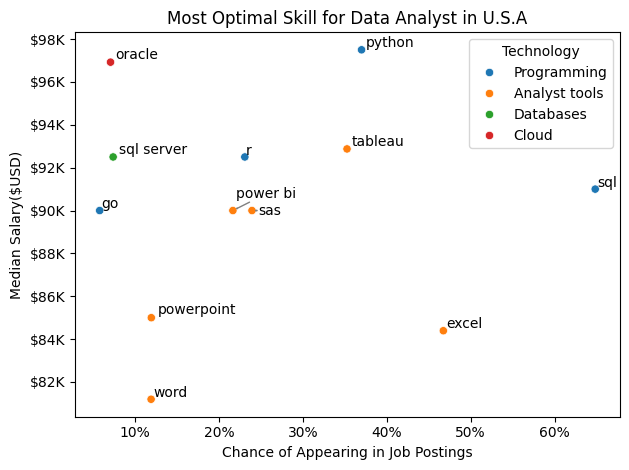

In [227]:
#plotting
sns.scatterplot(
    data = df_skills,
    x = "percent",
    y = "median",
    hue = "technology"
)

#plotting texts
texts = []
for skill in df_skills.index :
    texts.append(plt.text(x = df_skills.loc[skill, "percent"], y = df_skills.loc[skill, "median"], s = skill))
adjust_text(texts, arrowprops = dict(arrowstyle = "->", color = "gray", lw = 1))

#formatting
plt.legend().set_title("Technology")
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f"${int(y/1000)}K"))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{int(x)}%"))
plt.xlabel("Chance of Appearing in Job Postings")
plt.ylabel("Median Salary($USD)")
plt.title("Most Optimal Skill for Data Analyst in U.S.A")
plt.tight_layout()
plt.show()